This script is aiming to find the proper script to make a classicification of the images.

# Import pacakage

In [1]:
import tensorflow as tf
import numpy as np

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import numpy as np
import PIL
#import requests
from io import BytesIO
from IPython.display import display
%matplotlib inline

import os
import scipy

# Use in the model
from tensorflow.keras.layers import Dense, Dropout

# Crop Images

In [15]:
# category_names = ["background", "pharmaceutical", "sharps", "trace_chemo"]
category_names = ["pharmaceutical"]

for category_name in category_names:
    old_path = '/home/bowen/Documents/Ecomed/dataset/dataset_clean/' + category_name
    crop_path = '/home/bowen/Documents/Ecomed/dataset/dataset_clean_crop/' + category_name
    if not os.path.isdir(crop_path):
        os.mkdir(crop_path)
    dirs = os.listdir(old_path)
    for item in dirs:
        if os.path.isfile(old_path+'/'+item):
            im = PIL.Image.open(old_path+'/'+item)
            imCrop = im.crop((160, 0, 479, 319))
            imCrop.save(crop_path + '/' + item)

# Load Images

In [19]:
# Get the name of all the labels
home_path = '/home/bowen/Documents/Ecomed/'
data_path = '/home/bowen/Documents/Ecomed/dataset/dataset_clean_crop'
# class_names = os.listdir(data_path)
class_names = ["background", "pharmaceutical", "sharps", "trace_chemo"]

In [28]:
# Set up data generators that can read images from our dataset into Keras.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.5)

m_batch_size = 6

train_generator = datagen.flow_from_directory(
        data_path,
        target_size=(224, 224),
        batch_size=m_batch_size,
        class_mode='binary',
        subset='training')

validation_generator = datagen.flow_from_directory(
        data_path,
        target_size=(224, 224),
        batch_size=m_batch_size,
        class_mode='binary',
        subset='validation')            

Found 8924 images belonging to 4 classes.
Found 8923 images belonging to 4 classes.


sharps


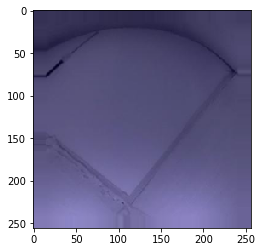

trace_chemo


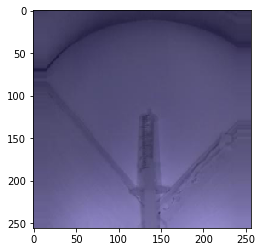

background


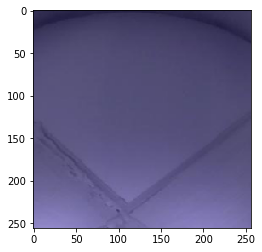

trace_chemo


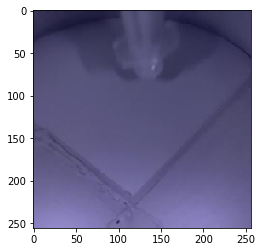

trace_chemo


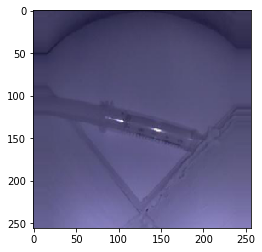

pharmaceutical


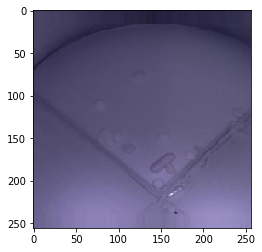

In [21]:
# # Show several images
data, labels = validation_generator.next()

for i, sample in enumerate(data):
    plt.imshow(sample)
    print(class_names[int(labels[i])])
    plt.show()

# MobileNet Model

In [22]:
gpu_index = 3

In [23]:
# Import mobilenet
with tf.device('/gpu:' + str(gpu_index)):
    mobilenet = tf.keras.applications.MobileNet(include_top=False, input_shape=[224, 224, 3], weights='imagenet')

In [24]:
# Add new output layers.
with tf.device('/gpu:' + str(gpu_index)):
    x = mobilenet.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    preds = tf.keras.layers.Dense(4, activation='softmax')(x)

    # Combine feature layers with our new output layers.
    model = tf.keras.Model(inputs=mobilenet.input, outputs=preds)
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

# Train the Model

In [25]:
# defintion of optimizer
with tf.device('/gpu:' + str(gpu_index)):
# opt = tf.keras.optimizers.SGD(0.001)
    opt = tf.train.GradientDescentOptimizer(0.001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
# definition of checkpoint
with tf.device('/gpu:' + str(gpu_index)):
    checkpoint_path = os.path.join(home_path, 'models', 'model_clean')
    if not os.path.isdir(checkpoint_path):
        os.mkdir(checkpoint_path)

    checkpoint_path = os.path.join(checkpoint_path, "model_clean.h5")
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True)

In [22]:
#model = tf.keras.models.load_model(os.path.join(home_path + 'models', "model_new_layer.h5"))

In [29]:
# train model
with tf.device('/gpu:' + str(gpu_index)):
    model.fit_generator(generator=train_generator,
                        validation_data=validation_generator, 
                        epochs=100,
                        callbacks=[cp_callback])

Epoch 1/100
1488/1488 [==============================] - 152s 102ms/step - loss: 0.3324 - acc: 0.8823 - val_loss: 0.3856 - val_acc: 0.8767
Epoch 2/100
1488/1488 [==============================] - 150s 101ms/step - loss: 0.2246 - acc: 0.9244 - val_loss: 0.3249 - val_acc: 0.9060
Epoch 3/100
1488/1488 [==============================] - 151s 102ms/step - loss: 0.1861 - acc: 0.9372 - val_loss: 0.2690 - val_acc: 0.9268
Epoch 4/100
1488/1488 [==============================] - 148s 100ms/step - loss: 0.1461 - acc: 0.9531 - val_loss: 0.2258 - val_acc: 0.9330
Epoch 5/100
1488/1488 [==============================] - 146s 98ms/step - loss: 0.1272 - acc: 0.9584 - val_loss: 0.2620 - val_acc: 0.9291
Epoch 6/100
1488/1488 [==============================] - 146s 98ms/step - loss: 0.1086 - acc: 0.9655 - val_loss: 0.3164 - val_acc: 0.9220
Epoch 7/100
1488/1488 [==============================] - 146s 98ms/step - loss: 0.1020 - acc: 0.9659 - val_loss: 0.2698 - val_acc: 0.9291
Epoch 8/100
1488/1488 [=======

KeyboardInterrupt: 

In [30]:
tf.contrib.saved_model.save_keras_model(model, home_path + 'models/model_clean')

INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tens

b'/home/bowen/Documents/Ecomed/models/model_clean/1552547053'

In [12]:
model.history